# Problem 1 - Digit Recognizer

### Imports

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
import tensorflow as tf 

import numpy as np
import matplotlib.pyplot as plt
import warnings, math, time

warnings.filterwarnings("ignore")

### The dataset

In [2]:
data = np.load('dataset.npz')
X = data['X']
y = data['y']

labels_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: 'A',
    11: 'B',
    12: 'C',
    13: 'D',
    14: 'E',
    15: 'F',
    16: 'Empty'
}

### Splitting the dataset

In [3]:
seed = 13
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

### Visualizing data

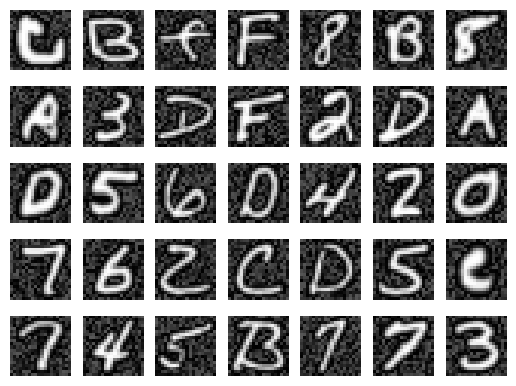

In [4]:
fig, axes = plt.subplots(5, 7)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(20, 20), vmin=0, vmax=255, cmap='gray')
    ax.axis('off')
plt.show()

### Visualizing data by class

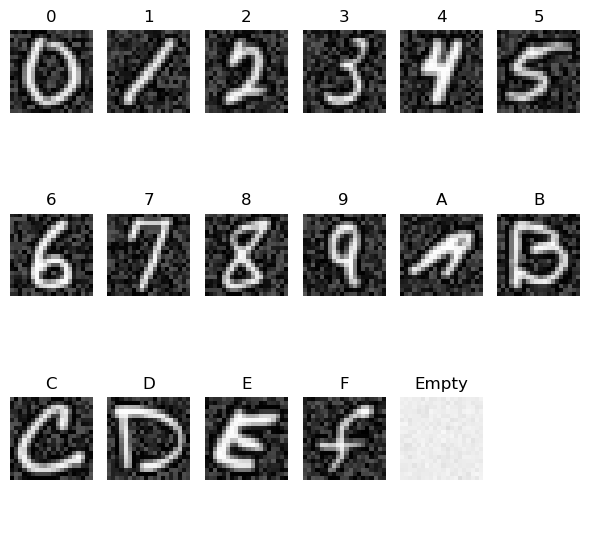

In [5]:
fig, axes = plt.subplots(3, 6, figsize=(6, 6))
axes = axes.ravel()
np.random.seed(42)

for class_label in range(17):
    class_indices = np.where(y_train == class_label)[0]
    random_index = np.random.choice(class_indices)
    
    axes[class_label].imshow(X_train[random_index].reshape(20, 20), vmin=0, vmax=255, cmap='gray')
    axes[class_label].axis('off')
    axes[class_label].set_title(labels_dict[class_label])
     
axes[-1].axis('off')
plt.tight_layout()
plt.show()

#### Class Distribution

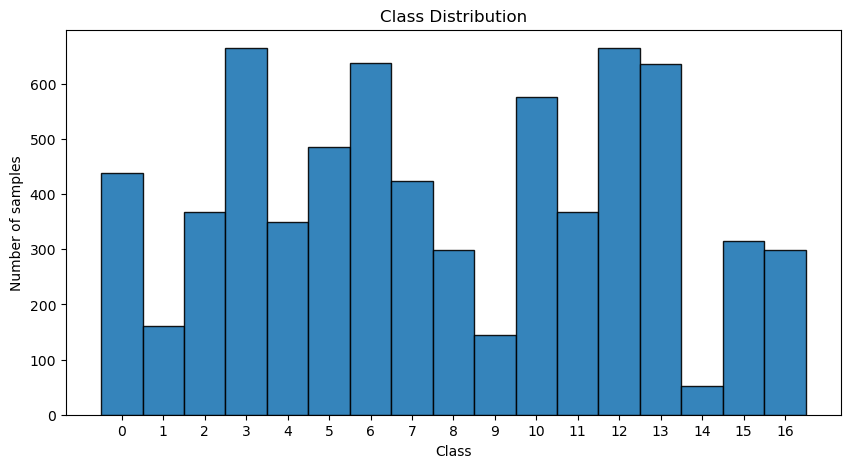

In [6]:
plt.figure(figsize=(10, 5))

plt.hist(y_train, bins=np.arange(18)-0.5, edgecolor="black", alpha=0.9)

plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Distribution")

plt.xticks(np.arange(17))
plt.show()

### Data Preprocessing

In [7]:
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_norm)
X_test = scaler.transform(X_test_norm)

### Model selection - Classifier 1

Here I use SVM

In [8]:
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

grid_svc = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train, y_train)

print("Best parameters for SVM:", grid_svc.best_params_)
best_svc = grid_svc.best_estimator_

y_pred_svc = best_svc.predict(X_test)
print(f"SVM Classification Report:\n{classification_report(y_test, y_pred_svc)}")

Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       188
           1       0.92      0.96      0.94        69
           2       0.94      0.89      0.91       158
           3       0.94      0.95      0.94       285
           4       0.90      0.90      0.90       150
           5       0.93      0.89      0.91       209
           6       0.96      0.96      0.96       274
           7       0.92      0.95      0.93       182
           8       0.87      0.85      0.86       128
           9       0.95      0.87      0.91        61
          10       0.91      0.94      0.92       248
          11       0.87      0.83      0.85       157
          12       0.94      0.98      0.96       285
          13       0.88      0.92      0.90       273
          14       1.00      0.55      0.71        22
          15       0.87      0.87      

### Model selection - Classifier 2

Here I use Random forest

In [9]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7]
}

grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print(f"Random Forest Classification Report:\n{classification_report(y_test, y_pred_rf)}")

Best parameters for Random Forest: {'max_depth': 7, 'n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       188
           1       0.89      0.86      0.87        69
           2       0.95      0.60      0.74       158
           3       0.69      0.94      0.80       285
           4       0.80      0.77      0.78       150
           5       0.80      0.65      0.72       209
           6       0.81      0.92      0.86       274
           7       0.77      0.93      0.84       182
           8       0.81      0.55      0.66       128
           9       1.00      0.13      0.23        61
          10       0.69      0.96      0.81       248
          11       0.75      0.50      0.60       157
          12       0.77      0.96      0.85       285
          13       0.74      0.78      0.76       273
          14       0.00      0.00      0.00        22
          15       0.87  

### Model selection - Classifier 3

Here i use neaural network. Inspired by this article from medium [handwritten-digit-recognition](https://medium.com/@azkardm/handwritten-digit-recognition-4dc904edb515).

In [10]:
start_time = time.time()
num_class = len(labels_dict)

X_train_tf = X_train.reshape(-1, 20, 20)
X_test_tf = X_test.reshape(-1, 20, 20)

# Layers
model_nn = tf.keras.models.Sequential([
    # input layer
    tf.keras.layers.InputLayer(input_shape=(20, 20)),
    # hidden layers
    tf.keras.layers.Reshape((20, 20, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # Output layer
    tf.keras.layers.Dense(num_class, activation='softmax')
])

model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_nn.fit(X_train_tf, y_train, epochs=10)

loss, nn_accuracy = model_nn.evaluate(X_test_tf, y_test)

end_time = time.time()
print(f"Running time: {(end_time - start_time):0.3f}")


Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6850 - loss: 1.0747
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9336 - loss: 0.2254
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9646 - loss: 0.1155
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9779 - loss: 0.0684
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9919 - loss: 0.0330
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9928 - loss: 0.0225
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9914 - loss: 0.0307
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9940 - loss: 0.0225
Epoch 9/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9920 - loss: 0.0202
Epoch 10/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0041
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9533 - loss: 0.2352
Running time: 7.651


### Classifier Evaluation

In [11]:
svc_accuracy = accuracy_score(y_test, y_pred_svc)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"SVM Test Accuracy: {svc_accuracy:0.3f}")
print(f"Random Forest Test Accuracy: {rf_accuracy:0.3f}")
print(f"Neural network Accuracy: {nn_accuracy:0.3f}\n")

accuracies = {
    'SVM': svc_accuracy,
    'Random Forest': rf_accuracy,
    'Neural Network': nn_accuracy
}
best_model_name = max(accuracies, key=accuracies.get)
if best_model_name == 'SVM':
    best_model = grid_svc
elif best_model_name == 'Random Forest':
    best_model = grid_rf
elif best_model_name == 'Neural Network':
    best_model = model_nn

print(f"Best model is {best_model_name} with accuracy: {accuracies[best_model_name] * 100:.2f}%")

SVM Test Accuracy: 0.920
Random Forest Test Accuracy: 0.782
Neural network Accuracy: 0.954

Best model is Neural Network with accuracy: 95.36%


### Vizulize the predicted data with confusion matrix

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


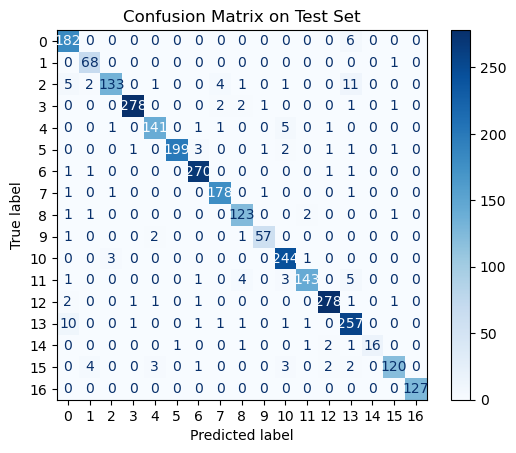

In [12]:
if isinstance(best_model, tf.keras.Model):
    X_test_nn = X_test_tf.reshape(-1, 20, 20, 1) 
    y_pred_probs = best_model.predict(X_test_nn)
    y_pred_test = np.argmax(y_pred_probs, axis=1)
else:
    y_pred_test = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

### Testing the classifier agianst the unseen data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


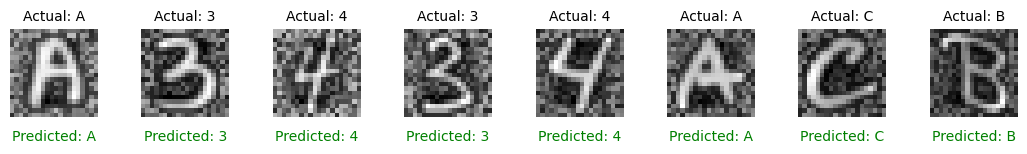

In [13]:
num_samples = 8
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
sample_true_labels = y_test[indices]

if best_model_name == 'SVM':
    sample_predicted_labels = y_pred_svc[indices]
elif best_model_name == 'Random Forest':
    sample_predicted_labels = y_pred_rf[indices]
elif best_model_name == 'Neural Network':
    sample_images_tf = sample_images.reshape(-1, 20, 20, 1) 

    y_pred_probs = best_model.predict(sample_images_tf)
    sample_predicted_labels = np.argmax(y_pred_probs, axis=1)

fig, axes = plt.subplots(1, num_samples, figsize=(13, 4))  
for i in range(num_samples):
    ax = axes[i]
    ax.imshow(sample_images[i].reshape(20, 20), cmap='gray')
    ax.axis('off')

    actual = labels_dict[sample_true_labels[i]]
    predicted = labels_dict[sample_predicted_labels[i]]

    if actual == predicted:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(f"Actual: {actual}", fontsize=10)
    ax.text(0.5, -0.15, f"Predicted: {predicted}", fontsize=10, color=color, ha='center', va='top', transform=ax.transAxes)

plt.subplots_adjust(wspace=0.5) 
plt.show()


### Perform cross-validation on the best model

Inspired by this github page: [how-to-use-k-fold-cross-validation-with-keras](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md)

In [14]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

if isinstance(best_model, tf.keras.Model):
    # Manual Cross-Validation
    scores  = []
    for fold, (train_i, val_i) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{k} working...")
        
        X_fold_train, X_fold_val = X[train_i], X[val_i]
        y_fold_train, y_fold_val = y[train_i], y[val_i]

        X_fold_train_norm = X_fold_train / 255.0
        X_fold_val_norm = X_fold_val / 255.0
        X_fold_train_scaled = scaler.fit_transform(X_fold_train_norm)
        X_fold_val_scaled = scaler.transform(X_fold_val_norm)

        X_train_fold = X_fold_train.reshape(-1, 20, 20)
        X_fold_val = X_fold_val.reshape(-1, 20, 20)

        model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=(20, 20)),
            tf.keras.layers.Reshape((20, 20, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_class, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train_fold, y_fold_train, epochs=10, batch_size=32, verbose=0)
        loss, accuracy = model.evaluate(X_fold_val, y_fold_val, verbose=0)

        scores.append(accuracy)
else:
    scores = best_model.evaluate(X_test, y_test, verbose=0)

print(f"\nMean cross-validation accuracy: {np.mean(scores):.3f}")
print(f"Standard deviation: {np.std(scores):.4f}")

Fold 1/5 working...
Fold 2/5 working...
Fold 3/5 working...
Fold 4/5 working...
Fold 5/5 working...

Mean cross-validation accuracy: 0.933
Standard deviation: 0.0051


# Problem 2: Dimensionality Reduction

### Determine Optimal Number of Components

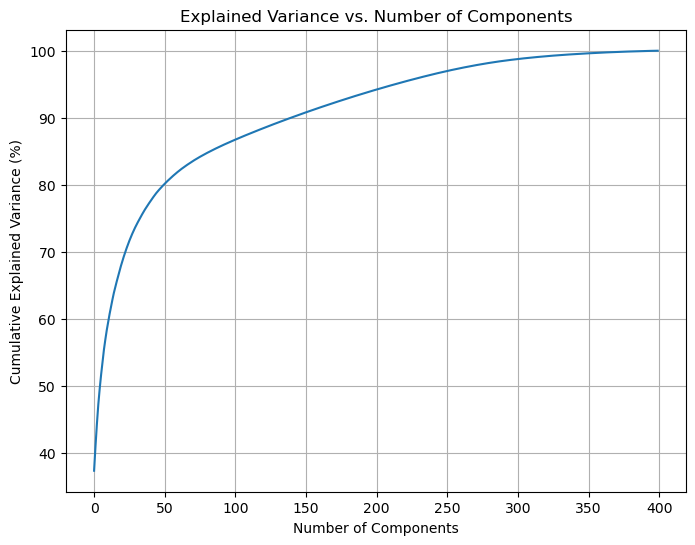

In [15]:
pca = PCA().fit(X_train)

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

We can choose $k$ such that we retain, for example, 95% of the variance.

In [16]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

k = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {k}")

Number of components explaining 95% variance: 214


### Transform Data Using PCA

In [17]:
pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### Train Classifier on Reduced Data

In [18]:
start_time = time.time()

model_pca = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(k,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_class, activation='softmax')
])


model_pca.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_pca.fit(X_train_pca, y_train, epochs=10)

end_time = time.time()
print(f"Running time: {(end_time - start_time):0.3f}")

Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3587 - loss: 2.1070
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7688 - loss: 0.7613
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8340 - loss: 0.5318
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8672 - loss: 0.4076
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8882 - loss: 0.3356
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9106 - loss: 0.2814  
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.9183 - loss: 0.2373
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9328 - loss: 0.2127
Epoch 9/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9370 - loss: 0.1886  
Epoch 10/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9459 - loss: 0.1620
Running time: 3.337


### Evaluate performance

Running time from running non-reduced data was $6.878s$, and is now only $3.058s$. \
But accuracy went from $94.51\%$ to $89.43\%$.

In [19]:
loss, accuracy_pca = model_pca.evaluate(X_test_pca, y_test)

print(f"Accuracy with PCA: {accuracy_pca * 100:.2f}%")
print(f"Accuracy without PCA: {nn_accuracy * 100:.2f}%")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.8877 - loss: 0.4216
Accuracy with PCA: 88.44%
Accuracy without PCA: 95.36%


# Problem 3: Detecting Out-of-Distribution Images

### The dataset

In [20]:
corrupted_data = np.load('corrupt_dataset.npz')
X_corrupted = corrupted_data['X']

X_corrupted_norm = X_corrupted / 255.0
X_corrupted_scaled = scaler.transform(X_corrupted_norm)

### Visualisation of the corrupted data

We have normal data, but  it seem to include images of clohtes like pants, sweater, dress too. 

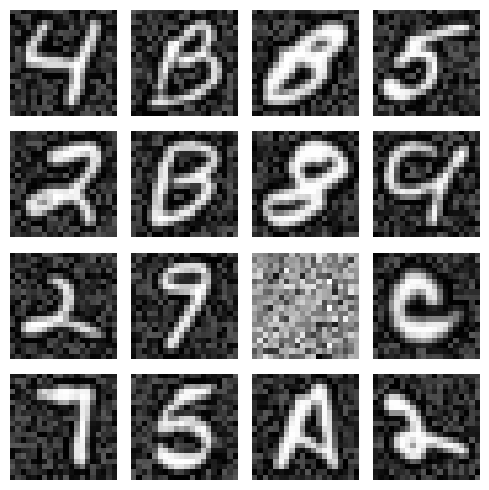

In [21]:
num_images = 16

plt.figure(figsize=(5, 5))
indices = np.random.choice(len(X_corrupted), num_images, replace=False)
for i, idx in enumerate(indices):
    image = X_corrupted[idx].reshape(20, 20)
    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Using One-Class SVM to detect outliers

In [22]:
pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train)
X_corrupted_pca = pca.transform(X_corrupted_scaled)

nu = expected_outlier_fraction = 85 / len(X_train_pca) + 0.05

ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=nu)
ocsvm.fit(X_train_pca)

predictions = ocsvm.predict(X_corrupted_pca)
inlier_indices = np.where(predictions == 1)[0]
outlier_indices = np.where(predictions == -1)[0]

print(f"Number of inliers (numbers/letters): {len(inlier_indices)}")
print(f"Number of outliers (possibly clothes): {len(outlier_indices)}")

Number of inliers (numbers/letters): 818
Number of outliers (possibly clothes): 117


### Visualisation of the outliers

As you can see. It detected many of them. Pants, shoes, empty images, bags. But it also got some wrong.

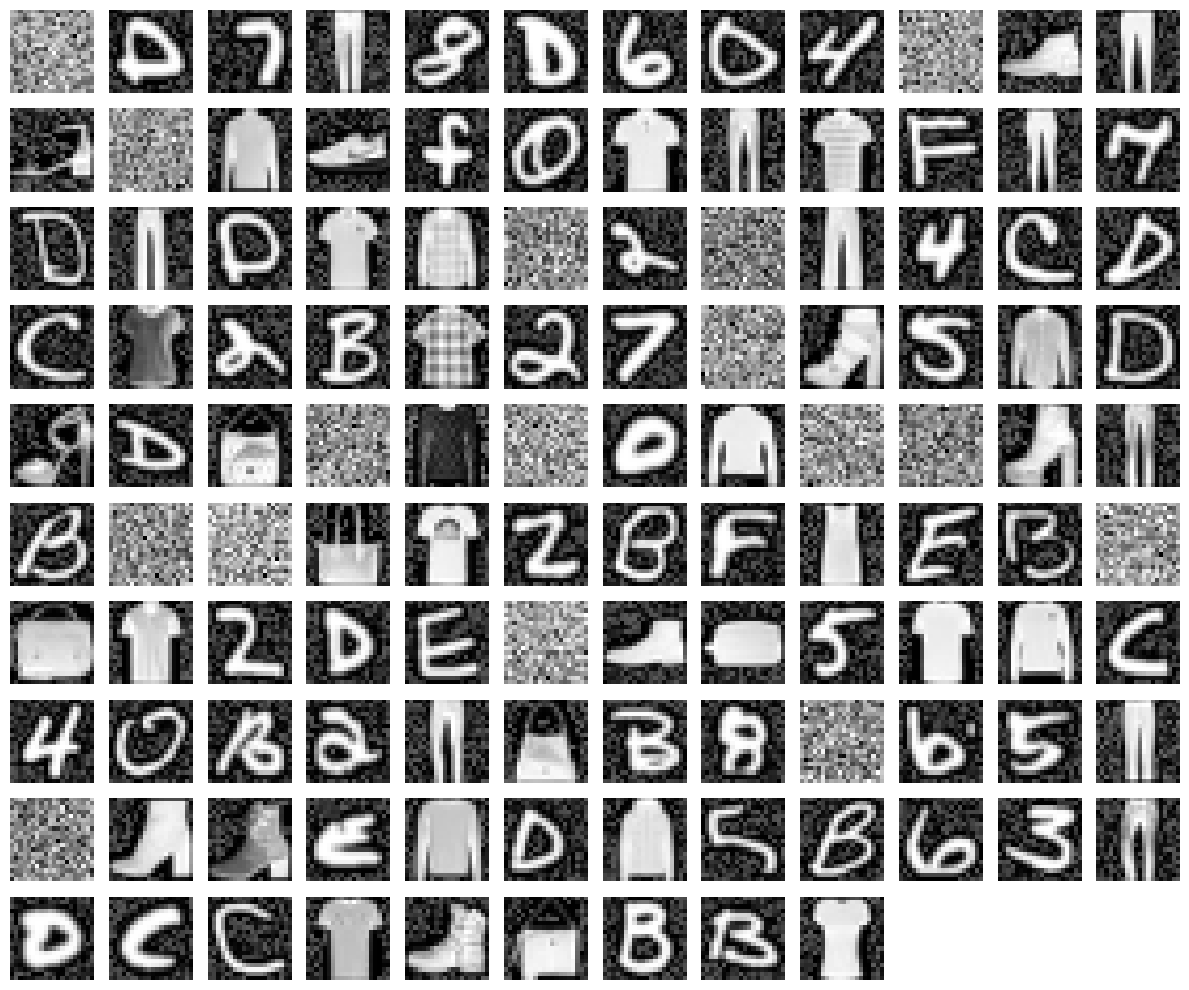

In [23]:
num_images = len(outlier_indices)
cols = 12
rows = math.ceil(num_images / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
axes = axes.flatten()
for i, idx in enumerate(outlier_indices):
    image = X_corrupted[idx].reshape(20, 20)
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

for i in range(len(outlier_indices), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()